<a href="https://colab.research.google.com/github/RFHertel/ESOF-4011/blob/main/Lab8_Sentiment_Analysis_w_LSTM_Normal_Emb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis with DNN ESOF 4011 Lab 8 Solution**

## Lab Instructor: Robert Hertel

Note: Please share all links with me in the future by pressing share in the top right corner

Introduction Format:

Student Name: Robert Hertel

Sudent ID: XXXXXX

Lab No.: 8

Colab link: https://colab.research.google.com/drive/1EUP46sgm0w5-NTvFQc_tczBRhadgK5Vo#scrollTo=Bt7gG8jggxuE



#Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from keras.preprocessing.text import Tokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import imdb
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import LSTM
from keras.layers import Conv1D



#Load the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
movie_reviews = pd.read_csv("/content/drive/MyDrive/Labs for AI/Lab 7 - Sentiment Analysis DNN/IMDB Dataset.csv/IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [ ]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
movie_reviews["review"][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

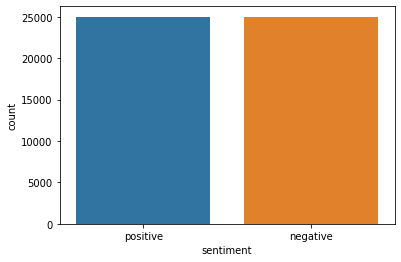

In [ ]:
sns.countplot(x='sentiment', data=movie_reviews)

#Data Preprocessing

Using the re library make the text form full sentences without needless characters

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
movie_reviews['review']

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

In [ ]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
X[2]

'I thought this was wonderful way to spend time on too hot summer weekend sitting in the air conditioned theater and watching light hearted comedy The plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer While some may be disappointed when they realize this is not Match Point Risk Addiction thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love This was the most d laughed at one of Woody comedies in years dare say decade While ve never been impressed with Scarlet Johanson in this she managed to tone down her sexy image and jumped right into average but spirited young woman This may not be the crown jewel of his career but it was wittier than Devil Wears Prada and more interesting than Superman great comedy to go see with friends '

In [ ]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
y[0]

1

In [ ]:
X_train_init, X_test_init, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
num_words = 5000 

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_init)

X_train = tokenizer.texts_to_sequences(X_train_init)
X_test = tokenizer.texts_to_sequences(X_test_init)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

#max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
Embed = Embedding(num_words, 32, input_length=maxlen)

#Create Models

In [ ]:
#Normal LSTM model asked for in the lab

def create_model(Embed, LSTMcells = 128, LSTMcells2 = 128): # top_words max_words || num_words, maxlen
    model = Sequential()
    
    model.add(Embed)
    model.add(LSTM(LSTMcells, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(LSTMcells2))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
#To create a Hybrid LSTM CNN can try this

def create_model2(Embed, LSTMcells = 128): # top_words max_words || num_words, maxlen
    model = Sequential()
    model.add(Embed)
    model.add(Conv1D(128, 5, activation='relu'))  
    model.add(MaxPooling1D(pool_size=2))
    #model.add(embedding_layer)
    model.add(LSTM(LSTMcells, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Evaluate / plot model

In [ ]:
def train_model(model, x_train, y_train, x_test, y_test, epochs=2, batch_size=1):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=2)
    
    loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    



In [ ]:
model = create_model(Embed = Embed)# top_words max_words || num_words, maxlen

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 32)            160000    
_________________________________________________________________
lstm (LSTM)                  (None, 80, 128)           82432     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 387,017
Trainable params: 387,017
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2
313/313 - 139s - loss: 0.4368 - accuracy: 0.7866 - val_loss: 0.3439 - val_accuracy: 0.8488
Epoch 2/2
313/313 - 118s - loss: 0.3287 - accuracy: 0.8608 - val_loss: 0.3410 - val_accuracy: 0.8506


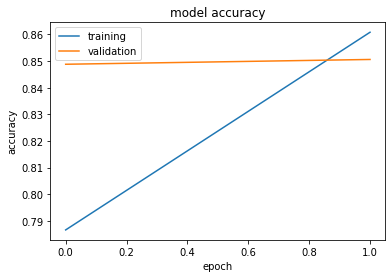

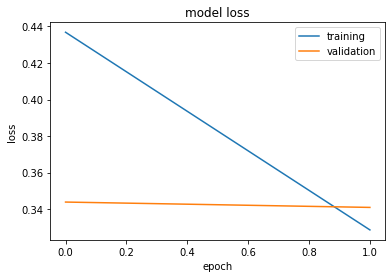

Accuracy: 85.06%


In [ ]:
train_model(model, X_train, y_train, X_test, y_test, epochs=2, batch_size=128)

# Predict Individually

In [ ]:
#Here print out the truth first and then the predictions of imdb reviews in the test set
test_sample_11 = X_test_init[40]
print(y_test[40])
test_sample_12 = X_test_init[41]
print(y_test[41])
test_sample_13 = X_test_init[42]
print(y_test[42])
test_sample_14 = X_test_init[43]
print(y_test[43])
test_sample_15 = X_test_init[34]
print(y_test[44])
test_sample_16 = X_test_init[45]
print(y_test[45])
test_sample_17 = X_test_init[46]
print(y_test[46])
test_sample_18 = X_test_init[47]
print(y_test[47])
test_sample_19 = X_test_init[48]
print(y_test[48])

test_samples = [test_sample_11, test_sample_12, test_sample_13, test_sample_14, test_sample_15, test_sample_16, test_sample_17, test_sample_18, test_sample_19]
test_sample_tokens = tokenizer.texts_to_sequences(test_samples) 

test_tokens_pad = pad_sequences(test_sample_tokens, maxlen=maxlen)
model.predict(x=test_tokens_pad)



0
1
0
0
1
1
1
1
1


array([[0.0212035 ],
       [0.58151656],
       [0.05010797],
       [0.08105922],
       [0.9636688 ],
       [0.9602838 ],
       [0.7105618 ],
       [0.9229344 ],
       [0.96831816]], dtype=float32)

# Create a Classification Report and Confusion Matrix

In [ ]:
X_test_init[40]

'If there was some weird inversed Oscar Academy awards festival this flick would win it all It has all the gods excellent plot extreme special effects coupled with extremely good acting skills and of course in every role there is celebrity superstar Well this could be the scenario if the world was inversed but it not Instead it the worst horror flick ever made not only bad actors that seem to read the scripts from teleprinter with bad dyslexia but also extremely low on special effects For example the devil costume which by the way is must see is something of the most hilarious ve ever seen Whenever saw that red black so called monster on screen couldn hold my laugh back And to top of things it looked like the funny creature was transported by conveyor belt Do not do the same mistake as did Checking IMDB seeing that the movie was released in had less than five votes and thinking Well it worth shot can be that bad Yes it could m not even going to waste more words on this movie '

In [ ]:
Y_pred = model.predict_classes(X_test,batch_size = 128) #val X_test Y_test

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
Y_pred_not_deprecated = model.predict((X_test))

In [ ]:
Y_pred_not_deprecated = np.where(Y_pred_not_deprecated > 0.5, 1, 0)

In [ ]:
Y_pred_not_deprecated

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [ ]:
Y_pred

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]], dtype=int32)

In [ ]:
confusion_matrix_sentiment = confusion_matrix(y_test, Y_pred_not_deprecated)

In [ ]:
print(confusion_matrix_sentiment)

[[4162  799]
 [ 695 4344]]


In [ ]:
classification_report_sentiment = classification_report(y_test, Y_pred_not_deprecated)

In [ ]:
print(classification_report_sentiment)

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4961
           1       0.84      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [ ]:
tf.keras.backend.clear_session()